# ヒストグラム その4: ヒストグラムの逆投影法
## 目的
このチュートリアルではヒストグラムの逆投影法を学ぶ．

## 理論
Michael J. Swain & Dana H. Ballard の [Indexing via color histograms](https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV/_downloads/swainballard.pdf) という論文で提案された方法である．

__簡潔に言うとこれは何か?__ 画像の領域分割や画像中の対象物体の検出に使われる．簡単に言うと，各画素が対象物体に属している確率を表す入力画像と同じサイズで単相の画像を作成する．さらに言うと，出力画像中で対象物体のように見える部分は白く，それ以外の部分は黒くなる．これは直観的な説明である(これ以上簡単には説明できない)．ヒストグラム逆投影法はcamshiftアルゴリズムなどに使われている．

__どのように実現するのか?__ 対象物体(ここでは「地面」，選手やその他の物体はさておき)を含む画像のヒストグラムを作成する．よりよい結果を得るには，対象物体はできる限り画像全体を占める必要がある．対象物体の色はグレースケール画像よりカラー画像で見た方が定義しやすいため，グレースケール・ヒストグラム(1次元ヒストグラム)よりカラー・ヒストグラム(2次元ヒストグラム)が好まれる．次に、このヒストグラムを画像に対して逆投影する．別の言い方をすると，各画素が「地面」に属す確率を計算し，それを見せる．妥当な閾値処理と組み合わせれば，画像中から地面だけが検出できる．



## Numpyのアルゴリズム
１． 初めに検出したい物体のカラー・ヒストグラム(‘M’ とする)と，検出に使う画像のカラー・ヒストグラム( ‘I’とする)の両方を求める（用いる[画像1](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_histograms/py_histogram_backprojection/Small_Red_Rose.jpg),
[画像2](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_histograms/py_histogram_backprojection/red-roses.jpg))

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#roi is the object or region of object we need to find
roi = cv2.imread('Small_Red_Rose.jpg')
hsv = cv2.cvtColor(roi,cv2.COLOR_BGR2HSV)

#target is the image we search in
target = cv2.imread('red-roses.jpg')
hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV)

# Find the histograms using calcHist. Can be done with np.histogram2d also
M = cv2.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )
I = cv2.calcHist([hsvt],[0, 1], None, [180, 256], [0, 180, 0, 256] )


２. 次に比率 $\displaystyle R = \frac{M}{I} $を計算する．そしてRを逆投影する，つまりRをパレットとして使い、それぞれの画素が対象物体である確率値に対応するる画像を作る `B(x,y) = R[h(x,y),s(x,y)]` ここでhはHue,sはsaturationを表する．その後以下の条件を適用する $B(x,y) = min[B(x,y), 1] $．

In [2]:
R = M/I
h,s,v = cv2.split(hsvt)
B = R[h.ravel(),s.ravel()]
B = np.minimum(B,1)
B = B.reshape(hsvt.shape[:2])

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


３．そして、円形カーネルを使ってフィルタリングする(畳み込む)， $B = D \ast B$, ここでDは円形カーネルを表すものとする．

In [3]:
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cv2.filter2D(B,-1,disc,B)
B = np.uint8(B)
cv2.normalize(B,B,0,255,cv2.NORM_MINMAX)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

4. 最大値を示す場所が対象物体の場所になる．画像において領域を検出したいのであれば，良い結果を得るために適した閾値を設定してみよう．

In [5]:
ret,thresh = cv2.threshold(B,50,255,0)


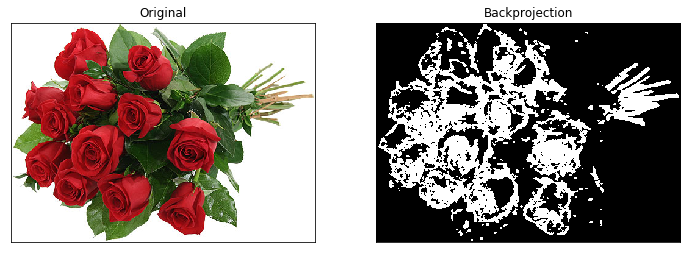

In [7]:
%matplotlib inline
target=cv2.cvtColor(target,cv2.COLOR_RGB2BGR)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1),plt.imshow(target)
plt.xticks([]),plt.yticks([]),plt.title('Original')
plt.subplot(1,2,2),plt.imshow(thresh,cmap='gray')
plt.xticks([]),plt.yticks([]),plt.title('Backprojection')

plt.show()

## OpenCVの逆投影法
OpenCVを使うのであれば [cv2.calcBackProject() ](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/histograms.html?highlight=calcbackproject#cv2.calcBackProject) 関数を使う．指定するパラメータは [cv2.calcHist()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/histograms.html?highlight=calchist#cv2.calcHist) 関数とほとんど同じである．パラメータの内の一つは対象物体のヒストグラムなので，計算しなければならない．また，対象物体のヒストグラムは関数に渡す前に正規化をしなければならない．出力は確率を表す画像になる．この出力に対して円形カーネルをconvolutionし，閾値処理をする．以下にコードと結果を示す: (使用する[画像1](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_histograms/py_histogram_backprojection/grass.png), [画像2](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_histograms/py_histogram_backprojection/messi5.jpg) )

以下に結果を示す．グラウンド全体を検出するために，青い長方形で囲った領域を対象物体のヒストグラムの計算に使った．

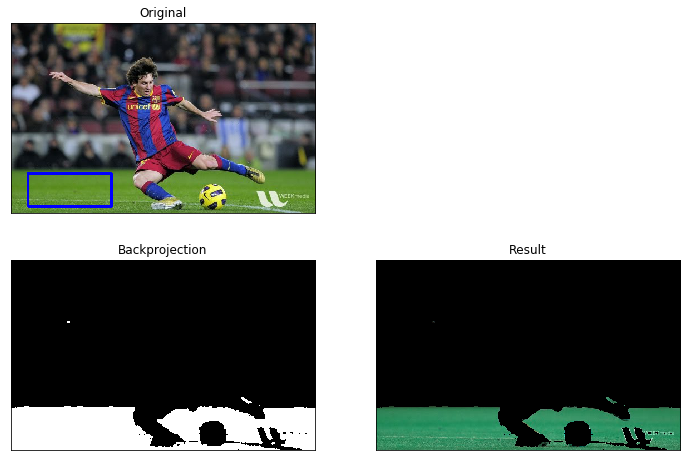

True

In [37]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

roi = cv2.imread('grass.png')
hsv = cv2.cvtColor(roi,cv2.COLOR_BGR2HSV)

target = cv2.imread('messi5.jpg')
hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV)

# calculating object histogram
roihist = cv2.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )

# normalize histogram and apply backprojection
cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
dst = cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)

# Now convolute with circular disc
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cv2.filter2D(dst,-1,disc,dst)

# threshold and binary AND
ret,thresh = cv2.threshold(dst,50,255,0)
thresh = cv2.merge((thresh,thresh,thresh))
res = cv2.bitwise_and(target,thresh)

####
plt.figure(figsize=(12,8))
plt.subplot(2,2,1),plt.imshow(cv2.cvtColor(target,cv2.COLOR_RGB2BGR))
plt.xticks([]),plt.yticks([]),plt.title('Original')
plt.subplot(2,2,3),plt.imshow(thresh,cmap='gray')
plt.xticks([]),plt.yticks([]),plt.title('Backprojection')
plt.subplot(2,2,4),plt.imshow(res)
plt.xticks([]),plt.yticks([]),plt.title('Result')
plt.show()
###
res = np.vstack((target,thresh,res))
cv2.imwrite('res.jpg',res)

## 目次
* [最初に戻る]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/usingOpenCV.html )
* 一つ上: [OpenCVでのヒストグラム](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/histogram.html) 
ヒストグラムについて学ぶ．
* 前の学習項目:  [ヒストグラム その3: 2次元ヒストグラム histogram2D.ipynb]
    (http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/histogram2D.html)<BR>
2次元ヒストグラムの計算及び描画方法
* 次の学習項目: [OpenCVの基底を使った画像の変換 contentsTransforms.ipynb ]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/contentsTransforms.html)<BR>
フーリエ変換，コサイン変換などの基底を使った画像変換について学ぶ．